y sample: [[-1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]]
ypred sample: [[-0.99999934]
 [-0.99999951]
 [-0.99999946]
 [-0.9999997 ]
 [-0.99999968]
 [-0.99999952]
 [-0.9999992 ]
 [-0.99999966]
 [-0.9999995 ]
 [-0.99999968]]
ypred bin: [[-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]]
Acuracia:  0.5


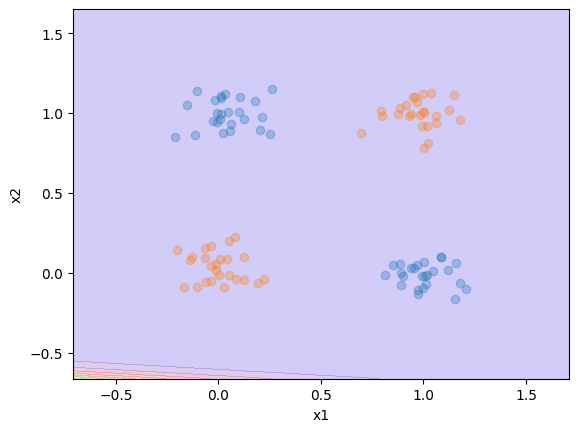

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def sign(a):
  return (a>0) * 2 - 1

def make_blobs_np(n_samples, n_features, centers, cluster_std, center_box=(-10.0, 10.0), random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    # Assume que 'centers' é uma lista de coordenadas dos centros.
    n_centers = len(centers)  # Determina o número de centros.
    center_coords = np.array(centers)  # Converte a lista de centros em um array Numpy.

    X = []
    y = []

    # Calcula o número de amostras por centro
    n_samples_per_center = n_samples // n_centers

    for i, center_coord in enumerate(center_coords):
        # Gera as amostras para cada centro
        samples = np.random.randn(n_samples_per_center, n_features) * cluster_std + center_coord
        X.append(samples)
        y.extend([i] * n_samples_per_center)

    # Concatena os resultados em um único array
    X = np.concatenate(X, axis=0)
    y = np.array(y)

    # Cria os índices baseados no tamanho real de X
    indices = np.arange(X.shape[0])

    # Embaralha os dados
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    return X, y

def plotDataset(X, y):
    plt.xlabel("x1")
    plt.ylabel("x2")
    # Certifique-se de que y é um vetor de uma dimensão antes de criar o conjunto
    y_flat = y.flatten()
    for k in set(y_flat):  # y_flat de uma dimensão
        plt.plot(X[:, 0][y_flat == k], X[:, 1][y_flat == k], "o", alpha=0.3)


#plotDataset(X, y)
def defineAxes(X):
    offset = 0.5
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]

def plotPredictions(mlp, X):
    axes = defineAxes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]

    activations = mlp.feedforward(X)
    y_pred = activations[-1]

    # Se y_pred tem mais de uma coluna (multicamada de saída) e ajuste se necessário
    if y_pred.shape[1] > 1:
        # Ajusta conforme necessário, aqui simplesmente pegamos a primeira coluna como exemplo
        y_pred = y_pred[:, 0]

    y_pred = y_pred.reshape(x0.shape)  # Certifique-se de que y_pred tem a forma correta para o contorno

    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    #plt.colorbar()
    #plotDataset(X, y)  # Plotar os dados sobre o contorno


def accuracy_score_np(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    if y_true.shape != y_pred.shape:
        raise ValueError("y_true e y_pred devem ter o mesmo tamanho.")
    accuracy = np.mean(y_true == y_pred)
    return accuracy


# Classe para o Multi Layer Perceptron com backpropagation
import numpy as np

# Definição das funções de ativação e suas derivadas
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)  # Assumindo que x já é a saída da função sigmoid

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - x ** 2  # Assumindo que x já é a saída da função tanh

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Classe MinhaMLP
class MinhaMLP:
    def __init__(self, layers, activation_functions, learning_rate=0.01):
        self.layers = layers
        self.learning_rate = learning_rate
        self.activation_functions = [self._get_activation_function(func) for func in activation_functions]
        self.weights = []
        self.biases = []
        self._initialize_weights()

    def _initialize_weights(self):
        #for i in range(1, len(self.layers)):
        #    self.weights.append(np.random.randn(self.layers[i-1], self.layers[i]) * 0.1)
        #    self.biases.append(np.zeros((1, self.layers[i])))

        # o resultado estava muito ruim e fui pesquisar formas de melhorar a eficiencia e resolvi tentar a abordagem da inicialização de pesos "avançada"
        for i in range(1, len(self.layers)):
          if self.activation_functions[i-1][0] == relu:
              # Inicialização de He
              stddev = np.sqrt(2.0 / self.layers[i-1])
          else:
              # Inicialização de Glorot/Xavier
              stddev = np.sqrt(2.0 / (self.layers[i-1] + self.layers[i]))
          self.weights.append(np.random.randn(self.layers[i-1], self.layers[i]) * stddev)
          self.biases.append(np.zeros((1, self.layers[i])))

    def _get_activation_function(self, name):
        if name == 'sigmoid':
            return sigmoid, sigmoid_derivative
        elif name == 'tanh':
            return tanh, tanh_derivative
        elif name == 'relu':
            return relu, relu_derivative
        else:
            raise ValueError("Unsupported activation function: " + name)

    def feedforward(self, X):
        activations = [X]
        for i in range(len(self.weights)):
            net_input = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            activation, _ = self.activation_functions[i]
            activations.append(activation(net_input))
        return activations

    def backpropagation(self, X, y):
        activations = self.feedforward(X)
        deltas = [None] * len(self.weights)

        # Calcula o erro na saída
        _, derivative = self.activation_functions[-1]
        delta = (activations[-1] - y) * derivative(activations[-1])
        deltas[-1] = delta

        # Propaga o erro para trás
        for i in reversed(range(len(deltas)-1)):
            _, derivative = self.activation_functions[i]
            delta = np.dot(deltas[i+1], self.weights[i+1].T) * derivative(activations[i+1])
            deltas[i] = delta

        # Atualiza os pesos e os biases
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * np.dot(activations[i].T, deltas[i])
            self.biases[i] -= self.learning_rate * np.sum(deltas[i], axis=0, keepdims=True)

    def train(self, X, y, epochs):
        for epoch in range(epochs):
            self.backpropagation(X, y)

# centers XOR
#def criaDatasetDificil(n=1000, centros=[[0,0],[1,0],[1,1],[0,1]]):
#  X, y = make_blobs_np(n_samples=n, centers=centros, cluster_std=1.5, n_features=2, random_state=42)
#  y = sign(np.array(y%2, dtype=int))
#  return X, y

#X, y = criaDatasetDificil()


# centers XOR
def criaDataset(n=100, func=lambda a, b: bool(a) != bool(b)):
  X, y = make_blobs_np(n_samples=n, centers=[[0,0],[1,0],[1,1],[0,1]], cluster_std=0.1, n_features=2, random_state=43)
  y = sign(np.array([func(x[0]>0.5, x[1]>0.5) for x in X], dtype=int))
  return X, y

X, y = criaDataset()


y = y.reshape(-1, 1)

# Exemplo de uso
layers = [2, 2, 1]
#O primeiro elemento (2) indica que a camada de entrada tem 2 neurônios.
#O segundo elemento (2) representa uma camada oculta com 2 neurônios.
#O terceiro e último elemento (1) indica que a camada de saída tem 1 neurônio.

#activation_functions = ['sigmoid', 'sigmoid']  # Usando sigmoid em todas as camadas
activation_functions = ['tanh', 'tanh']  # Usando tanh em todas as camadas
learning_rate = 0.09
epochs = 3000

mlp = MinhaMLP(layers, activation_functions, learning_rate)

# Treinando o MLP
mlp.train(X, y, epochs)

plotPredictions(mlp, X)
plotDataset(X,y)

ypred_1 = mlp.feedforward(X)[-1]  # Saídas da rede - ativações da última camada da lista de ativações retornadas
ypred_binario = np.where(ypred_1 >= 0, 1, -1)

print("y sample:", y[:10])
print("ypred sample:", ypred_1[:10])
print("ypred bin:", ypred_binario[:10])

print("Acuracia: ", accuracy_score_np(y, ypred_binario))

